# Program to prepare data & train NNs
---

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
F_ID = "44194"

df = pd.read_csv(f"data/intervals/df/{F_ID}_data.csv")
# df.describe()

In [3]:
def normalise_series(data):
    max_point, min_point, median_value = data.max(), data.min(), np.median(data)
    return (data - median_value) / abs(max_point - min_point)

In [4]:
data = []

l_edge = 0
POINTS_DIM = 1024
step = 100

while l_edge + POINTS_DIM < df.shape[0]:
    df_slice = df.iloc[l_edge:l_edge + POINTS_DIM]
    data.append([normalise_series(df_slice.ch1.to_numpy()), 
                 df_slice.ch1_marked.to_numpy()])
    l_edge += step

if l_edge + POINTS_DIM - step != df.shape[0] - 1:
    # print(df.shape[0] - l_edge)
    df_slice = df.iloc[df.shape[0] - POINTS_DIM:]
    data.append([normalise_series(df_slice.ch1.to_numpy()),
                df_slice.ch1_marked.to_numpy()])

data_array = np.array(data)

data_array.shape

(753, 2, 1024)

In [5]:
# !pip install tensorflow

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(data_array[:, 0], data_array[:, 1], test_size=0.1, random_state=42)
X_train, y_train = data_array[:, 0], data_array[:, 1]
# print(X_train[:10], y_train[:10])

In [8]:
X_train.shape

(753, 1024)

In [9]:
def unet_model():

    #Входной слой
    inputs = tf.keras.layers.Input(shape=(POINTS_DIM, 1,))
    conv_1 = tf.keras.layers.Conv1D(64, 4, 
                                    activation=tf.keras.layers.LeakyReLU(),
                                    strides=2, padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(inputs)
    #Сворачиваем
    conv_1_1 = tf.keras.layers.Conv1D(128, 4, 
                                      activation=tf.keras.layers.LeakyReLU(), 
                                      strides=2,
                                      padding='same', 
                                      kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = tf.keras.layers.BatchNormalization()(conv_1_1)

    #2
    conv_2 = tf.keras.layers.Conv1D(256, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization()(conv_2)

    #3
    conv_3 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_2)
    batch_norm_3 = tf.keras.layers.BatchNormalization()(conv_3)

    #4
    conv_4 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_3)
    batch_norm_4 = tf.keras.layers.BatchNormalization()(conv_4)

    #5
    conv_5 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_4)
    batch_norm_5 = tf.keras.layers.BatchNormalization()(conv_5)

    #6
    conv_6 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_5)

    #Разворачиваем
    #1
    up_1 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = tf.keras.layers.BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = tf.keras.layers.Dropout(0.25)(batch_up_1)

    #2
    up_2 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = tf.keras.layers.BatchNormalization()(up_2)
    batch_up_2 = tf.keras.layers.Dropout(0.25)(batch_up_2)




    #3
    up_3 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = tf.keras.layers.BatchNormalization()(up_3)
    batch_up_3 = tf.keras.layers.Dropout(0.25)(batch_up_3)




    #4
    up_4 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = tf.keras.layers.BatchNormalization()(up_4)


    #5
    up_5 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = tf.keras.layers.BatchNormalization()(up_5)


    #6
    up_6 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = tf.keras.layers.BatchNormalization()(up_6)


    #Выходной слой
    max_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_up_6)
    flat = tf.keras.layers.Flatten()(max_pool)
    flat = tf.keras.layers.Dropout(0.1)(flat, training=True)
    outputs = tf.keras.layers.Dense(POINTS_DIM, activation="sigmoid")(flat)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = unet_model()

In [11]:
def focal_loss(y_true, y_pred, alpha=0.1, gamma=2.0):
    bce = K.binary_crossentropy(y_true, y_pred)

    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

    alpha_factor = y_true * alpha + ((1 - alpha) * (1 - y_true))
    modulating_factor = K.pow((1 - p_t), gamma)

    # compute the final loss and return
    return K.mean(alpha_factor * modulating_factor * bce, axis=-1)

def dice_bce_loss(y_pred, y_true):
    def dice_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        
        return 1 - numerator / denominator
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [12]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

---
## Learning side
---

In [13]:
NUM_EPOCHS = 100
ckpt_v = 3
checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}.weights.h5'
callbacks_metric = 'val_precision'
callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                     save_weights_only=True,
                                                     monitor=callbacks_metric,
                                                     mode='max',
                                                     save_best_only=True)]

In [14]:
model.compile(optimizer='adam', loss=dice_bce_loss,
                  metrics=['acc', precision, recall])
model.load_weights(checkpoint_filepath)

D:\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 76 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
model.compile(optimizer='adam', loss=dice_bce_loss,
                  metrics=['acc', precision, recall])
model.fit(X_train, y_train, epochs=NUM_EPOCHS,callbacks=callbacks_list, validation_split=0.2, batch_size=64)
model.load_weights(checkpoint_filepath)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - acc: 0.0076 - loss: 1.0901 - precision: 0.7169 - recall: 0.7627 - val_acc: 0.0000e+00 - val_loss: 0.7599 - val_precision: 0.5503 - val_recall: 0.9192
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.0063 - loss: 0.7086 - precision: 0.7934 - recall: 0.7803 - val_acc: 0.0000e+00 - val_loss: 0.9920 - val_precision: 0.5107 - val_recall: 0.6716
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - acc: 0.0054 - loss: 0.5487 - precision: 0.8401 - recall: 0.8397 - val_acc: 0.0132 - val_loss: 1.1376 - val_precision: 0.5587 - val_recall: 0.6631
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.0096 - loss: 0.4969 - precision: 0.8489 - recall: 0.8451 - val_acc: 0.0000e+00 - val_loss: 0.9560 - val_precision: 0.5246 - val_recall: 0.8505
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - acc: 0.0074 - loss: 0.4379 - precision: 0.8679 - recall: 0.8756 - val_acc: 0.0066 - val_loss: 0.8385 - val_precision: 0.5286 - val_recall: 

---
## Marking side
---

In [15]:
ckpt_v = 3
checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}.weights.h5'

model.load_weights(checkpoint_filepath)

In [25]:
import os.path
from source.Files_operating import read_dataFile

interval_path = "data/intervals/"
signal_path = "data/d-alpha/"

check_filename = "sht44185"
check_F_ID = check_filename[-5:]

if os.path.isfile(f"data/intervals/df/{check_F_ID}_data.csv"):
    new_df = pd.read_csv(f"data/intervals/df/{check_F_ID}_data.csv", sep=",")
else:
    new_df = read_dataFile(interval_path + check_filename + "_exportGlobus2.dat", F_ID)
    new_df["ch1_marked"] = pd.Series([0] * df.shape[0])

new_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/intervals/sht44185_exportGlobus2.dat'

In [26]:
l_edge = 0
POINTS_DIM = 1024
step = 256

# slice_data = X_train
# print(slice_data.shape)

# predictions = model.predict(np.array([normalise_series(new_df.loc[l_edge:l_edge + POINTS_DIM - 1, "ch1"])]))
# print(predictions.shape)

while l_edge + POINTS_DIM < new_df.shape[0]:
    predictions = model.predict(np.array([normalise_series(new_df.loc[l_edge:l_edge + POINTS_DIM - 1, "ch1"])]))
    for i in range(0, POINTS_DIM):
        new_df.loc[l_edge + i, "ch1_marked"] = predictions[0][i]  # min(new_df.loc[l_edge + i, "ch1_marked"] + predictions[0][i], 1)
    l_edge += step

if l_edge + POINTS_DIM - step != new_df.shape[0] - 1:
    predictions = model.predict(np.array([new_df.loc[new_df.shape[0] - POINTS_DIM:new_df.shape[0], "ch1"]]))
    for i in range(0, POINTS_DIM):
        new_df.loc[new_df.shape[0] - POINTS_DIM + i, "ch1_marked"] = predictions[0][i]  # min(new_df.loc[new_df.shape[0] - POINTS_DIM + i, "ch1_marked"] + predictions[0][i], 1)

new_df.head()
new_df.to_csv(f"data/intervals/df/{check_F_ID}_data.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

Input start index [0:76155]:  3250


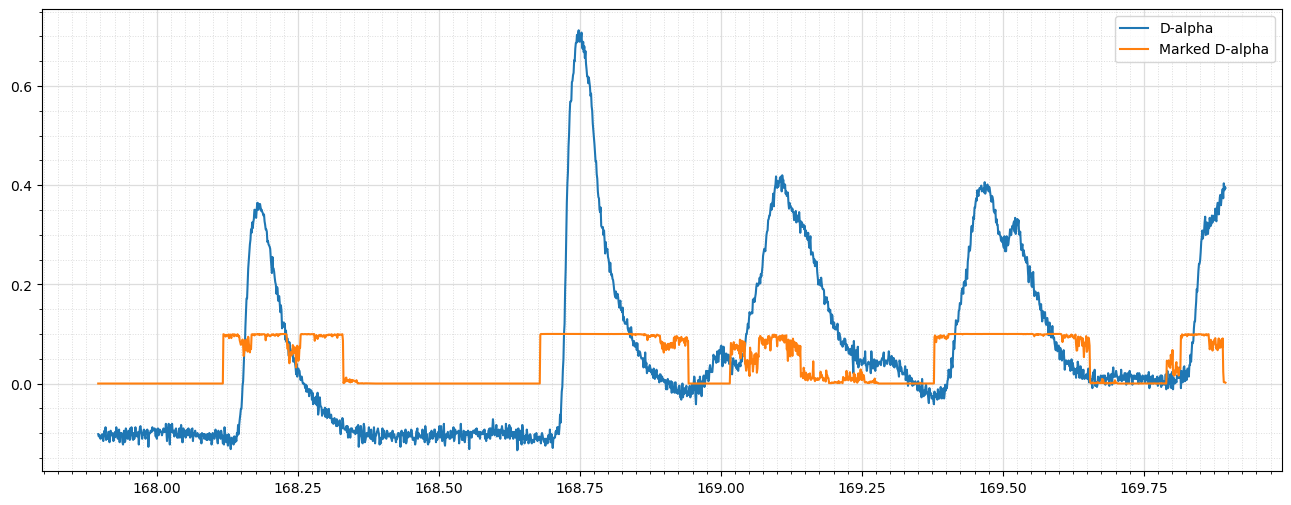

KeyboardInterrupt: Interrupted by user

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

l_edge = int(input(f"Input start index [0:{new_df.shape[0]}]: ").strip().split()[0])
step = 1500
width = 2000

while l_edge < new_df.shape[0]:
    fig, ax = plt.subplots()

    fig.set_figwidth(16)
    fig.set_figheight(6)

    r_edge = min(l_edge + width, new_df.shape[0])

    ax.plot(range(l_edge, r_edge), normalise_series(new_df.ch1)[l_edge:r_edge], label="D-alpha")  # new_df.iloc[l_edge:r_edge].t
    # ax.plot(range(l_edge, r_edge), new_df.ch1_filter_norm[l_edge:r_edge], label="Filtered D-alpha")
    ax.plot(range(l_edge, r_edge), new_df.ch1_marked[l_edge:r_edge] / 10, label="Marked D-alpha")

    ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.legend()
    plt.show()

    res = list(map(int, input("Input index pairs of ELM fragments:\n").strip().split()))
    for i in range(0, len(res), 2):
        if (new_df.loc[res[i]:res[i + 1], "ch1_marked"] == 1).all():
            new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 0
        elif (new_df.loc[res[i]:res[i + 1], "ch1_marked"] == 1).any():
            if input("Input y to set 1, n to set 0").lower() in ["y", "н"]:
                new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 1
            else:
                new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 0
        else:
            new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 1

    plt.close()
    plt.clf()
    l_edge += step

---
## Saving side
---

In [30]:
neu_version = 1
model.save(f"models/unet_v{neu_version}.keras")